In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pip install quandl

In [3]:
import quandl

# How to determine if there is actually a real flow of money supply into a crpyto?

I think if I can answer wether the demand is due to real new money supply and not just traders pumping prices using other crypto or even fiat, I'll be able to predict price of a crpyto better than other market pariticpants.

In [4]:
ethusd = quandl.get("BITFINEX/ETHUSD", authtoken="Jy-C4ogjQjicmLjayJuA")
btcusd = quandl.get("BITFINEX/BTCUSD", authtoken="Jy-C4ogjQjicmLjayJuA")

In [5]:
btceth = pd.merge(btcusd, ethusd, left_on = 'Date', right_on = 'Date', how = 'inner')

In [6]:
btceth = btceth.loc[:,['Last_x','Last_y']].rename(columns = {'Last_x':'BTC_last','Last_y':'ETH_last'})

In [7]:
btc = btceth.BTC_last.values.astype(float)
eth = btceth.ETH_last.values.astype(float)

In [8]:
btc_mean, btc_std = btc.mean(), btc.std()
eth_mean, eth_std = eth.mean(), eth.std()

btc = (btc - btc_mean)/btc_std
eth = (eth - eth_mean)/eth_std

In [24]:
plt.style.use('seaborn')

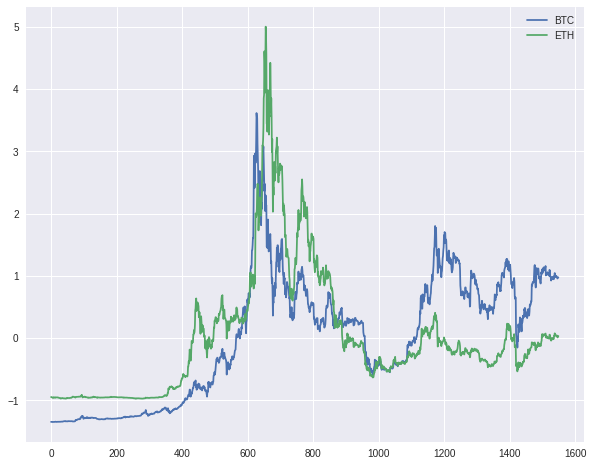

In [25]:
plt.subplots(figsize = (10,8))

plt.plot(btc)
plt.plot(eth)
plt.legend(['BTC','ETH'])
plt.show()

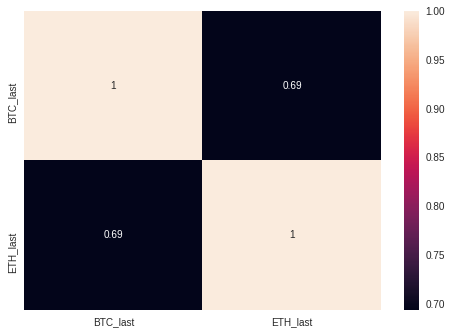

In [26]:
import seaborn as sn

sn.heatmap(btceth.corr(), annot = True)

In [11]:
def univariate_data(dataset, start, end, history_size, target_size):

  n_features = dataset.shape[1]

  data = []
  labels = []

  if not end:
    end = len(dataset)-target_size
  else:
    end = end - target_size
  
  start = start + history_size

  for i in range(start, end):
    data.append(np.array(dataset[i-history_size:i]).reshape(history_size, n_features))
    labels.append(dataset[i:i+target_size,1])

  labels = np.array(labels)
  labels = labels.reshape(labels.shape[0],)

  return np.array(data), labels

In [12]:
data_arr = btceth.values.astype(float)

In [13]:
TRAIN_SIZE = int(len(btceth)*0.95)

In [14]:
btc_mean = data_arr[:TRAIN_SIZE,0].mean()
btc_std = data_arr[:TRAIN_SIZE,0].std()

eth_mean = data_arr[:TRAIN_SIZE,1].mean()
eth_std = data_arr[:TRAIN_SIZE,1].std()

In [15]:
data_arr[:,0] = (data_arr[:,0] - btc_mean)/btc_std
data_arr[:,1] = (data_arr[:,1] - eth_mean)/eth_std

In [60]:
X_train, y_train = univariate_data(data_arr, 0, TRAIN_SIZE, 14, 1)
X_test, y_test = univariate_data(data_arr, TRAIN_SIZE, len(btceth),14, 1)

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(100).batch(20).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.batch(20).repeat()

In [62]:
lstm_model = tf.keras.Sequential([tf.keras.layers.LSTM(units = 14, input_shape = X_train.shape[1:]),
                                  tf.keras.layers.Dense(1)])

In [63]:
lstm_model.compile(optimizer='adam', loss = 'mse')

In [64]:
history = lstm_model.fit(train_dataset, epochs = 10, steps_per_epoch=1000, validation_data=val_dataset, validation_steps=50)

Epoch 1/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0898 - val_loss: 9.3451e-04
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0131 - val_loss: 0.0013
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0108 - val_loss: 0.0012
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0095 - val_loss: 7.3011e-04
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0091 - val_loss: 0.0015
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0083 - val_loss: 6.9044e-04
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 9/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0077 - val_loss: 0.0013
Epoch 10/10
1000/1000 [==============================] - 6s 6ms/step -

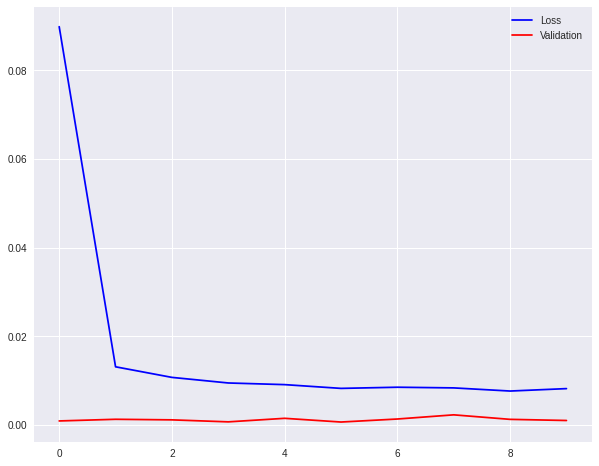

In [65]:
plt.subplots(figsize = (10,8))

plt.plot(history.history['loss'], color = 'blue')
plt.plot(history.history['val_loss'], color = 'red')

plt.legend(['Loss','Validation'])
plt.show()

loss function is decreasing while validation loss stays the same. If I understand correctly then it means I should reduce number of epochs.

In [66]:
def timesteps(x):
  return range(-len(x),0)

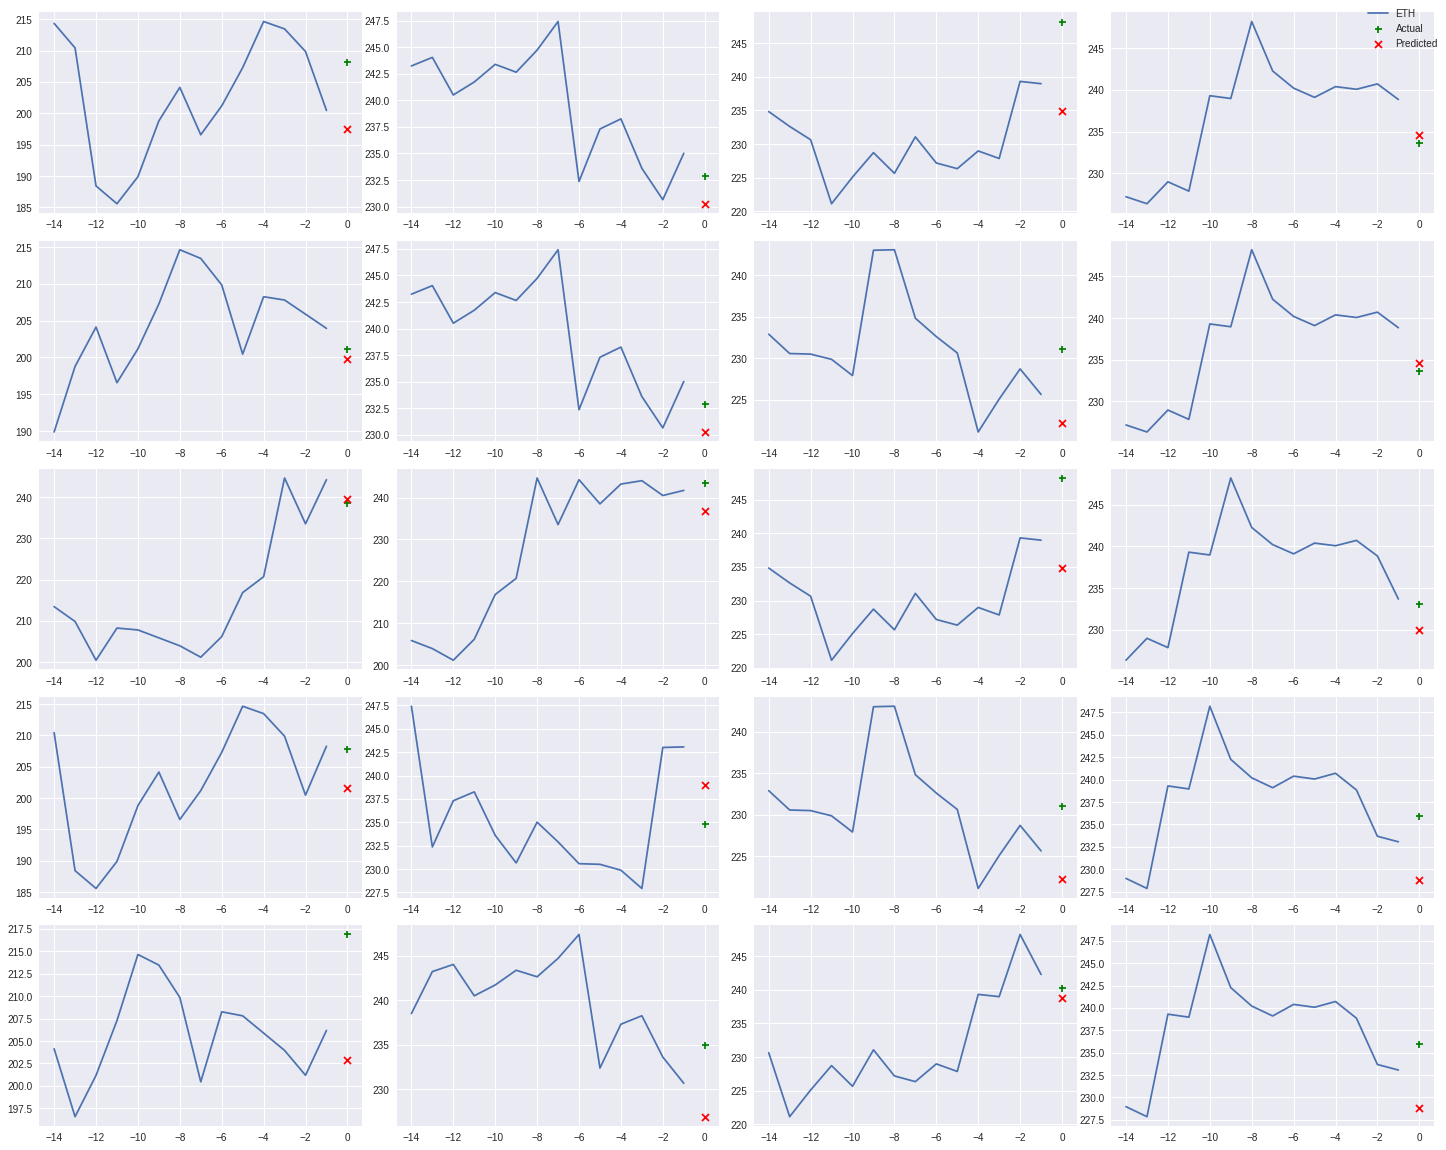

In [68]:
np.random.seed(1)

fig, ax = plt.subplots(5, 4, figsize = (20,16))

for i, (x,y) in enumerate(val_dataset.take(20)):
  
  random_ = np.random.randint(len(y.numpy()))
  y_ = y.numpy()
  y_ = y_[random_] * eth_std + eth_mean

  y_hat = lstm_model.predict(np.array([x[random_]]))[0][0]*eth_std + eth_mean
  history = x[random_].numpy()*eth_std+eth_mean

  row = int(i/4)
  col = i % 4

  ax[row][col].plot(timesteps(history), history[:,1])
  ax[row][col].scatter(0, y_, marker = '+', color ='green')
  ax[row][col].scatter(0, y_hat, marker = 'x', color = 'red')

fig.legend(['ETH','Actual','Predicted'])  
plt.tight_layout()

Lets try and predict ETH price for tomrrow (20 July)

In [69]:
july_20_price = btceth.iloc[-14:,:].values.astype(float)
july_20_price[:,0] = (july_20_price[:,0] - btc_mean) / btc_std
july_20_price[:,1] = (july_20_price[:,1] - eth_mean) / eth_std

In [70]:
lstm_model.predict(np.array([july_20_price]))[0][0]*eth_std + eth_mean

233.4176954371492

I want to try and see how many times could the network predict just the direction correctly. I think it is the most important factor when trying to predict time series data. Of course, one of the pitfalls of such model is that would probably never be able to predict a crash or a huge surge in prices.

In [71]:
def hit_or_miss(previous, actual, expected):
  if expected > previous: #expecting increase
    if actual > previous:
      return 1
  elif expected < previous: #expecting decrease
    if actual < previous:
      return 1
  return 0

In [72]:
def heuristic(t_0, t_1, t_2):
  if t_2 < t_1: #Price have decreased
    if t_1 < t_0:
      return 1
  elif t_2 > t_1:
    if t_1 > t_0:
      return 1
  return 0

In [73]:
from scipy.stats import binom

In [74]:
batch_size = 20

totals = 0
hits_totals = 0
heuristic_rule = 0

for x,y in val_dataset.take(100):
  total = 0
  hit = 0 
  heur = 0

  prediction = lstm_model.predict(x)*eth_std+eth_mean
  actual = y*eth_std+eth_mean
  miss = actual - prediction
  for i in range(0,len(y)):
    previous_two_days = x.numpy()[i][12,1]*eth_std + eth_mean
    previous = x.numpy()[i][13,1]*eth_std + eth_mean
    y_hat = prediction[:,0][i]
    y_ = actual.numpy()[i]
    total += 1
    hit += hit_or_miss(previous, y_, y_hat)
    heur += heuristic(previous_two_days, previous, y_)
    #print('Predicted: %.1f, Actual: %.1f, Previous: %.1f' % (prediction[:,0][i], actual.numpy()[i], previous))

  #print('Total in batch: {}, Direction hit: {}'.format(total, hit))
  totals += total
  heuristic_rule += heur
  hits_totals += hit


print('The network has predicted the direction correctly in %.3f of the samples' % (hits_totals/totals))
print('Probability of hitting the direction correctly in %.f or more, out of %.f trials is %.4f '% (hits_totals , totals,1-binom.cdf(hits_totals, totals, 0.5)))
print('Simple heuristic rule would predict correct %.f out of %.3f' % (heuristic_rule, totals))

The network has predicted the direction correctly in 0.556 of the samples
Probability of hitting the direction correctly in 875 or more, out of 1575 trials is 0.0000 
Simple heuristic rule would predict correct 725 out of 1575.000


So running the binomial test under the assumption of p = 0.5, the result is significant (p < 0.0001) yet I think those statistic tests are useless for big data inference. Any small varation would make the results significant. What encourage me a little bit is the fact that the model predicted better than simple heuristic test. The heuristic test is just predicting the same direction as the day before! It predicted correctly in 725. 150 less than the model.